In [1]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

In [2]:
prompts = [json.loads(x) for x in open('../data/prepped_questions.json').read().split('\n')][0]

In [3]:
#make a nice dataframe because that's easiest for me to play with.
temp = (json.loads(x) for x in open('../data/outputs/large_10000_counterfactuals.json'))
outputs = ['gold_present', 'wrong_present', 'gold2_present', 'wrong2_present', 'out', 'out2', 'order']
responses = pd.DataFrame(columns=outputs)

for item in temp:
    ident = [x for x in item.keys()][0]

    outs = [x for x in item.values()][0]
    temps = [outs[x] for x in outputs]
    responses.loc[ident] = temps

In [4]:
responses.head(5)

,gold_present,wrong_present,gold2_present,wrong2_present,out,out2,order
2wiki-82306e0e088111ebbd6dac1f6bf848b6,True,False,True,False,Allen Holden,Ainhoa Artolazábal,orig
2wiki-1c700497085211ebbd58ac1f6bf848b6,True,False,True,False,Gerd Cintl,Léa Drucker,switched
2wiki-7a6f7a0208cc11ebbd93ac1f6bf848b6,True,False,True,False,"Clark Kerr ( May 17, 1911 – December 1",François Barrer( François Barrier) was born,switched
hotpot-5ac538b25542994611c8b435,True,False,True,False,The World's Greatest Athlete,"Invincible (2006) was released last,",orig
2wiki-f9ab5ccb08d911ebbd9cac1f6bf848b6,True,False,False,False,Yevgeny Primakov Jr. is younger,[],orig


In [5]:
#Drop prompts that did not parse counterfactual creation correctly

responses.drop('hotpot-5ae4f47355429960a22e0224', inplace=True)
responses.drop('hotpot-5ab62cca554299637185c671', inplace=True)

In [6]:
c=0
for i in responses.itertuples():
    if (type(i.out) == list) or (type(i.out2) == list) or (type(i.gold_present) == list) or (type(i.wrong_present) == list) or (type(i.gold2_present) == list) or (type(i.wrong2_present) == list):
        c+=1
    if (type(i.out) == list):
        responses.loc[i.Index, 'out'] = ''
    if (type(i.out2) == list):
        responses.loc[i.Index, 'out2'] = ''
    if (type(i.gold_present) == list):
        responses.loc[i.Index, 'gold_present'] = False
    if (type(i.wrong_present) == list):
        responses.loc[i.Index, 'wrong_present'] = False
    if (type(i.gold2_present) == list):
        responses.loc[i.Index, 'gold2_present'] = False
    if (type(i.wrong2_present) == list):
        responses.loc[i.Index, 'wrong2_present'] = False

print(responses.shape)

print(f'{c} gave at least one empty response')

(9677, 7)
2633 gave at least one empty response


In [7]:
print(responses.shape) #9678

# remove the ones where the output is a list, as that means the response was empty for whatever reason
for i in responses.itertuples():
    if (type(i.out) == list) or (type(i.out2) == list) or (type(i.gold_present) == list) or (type(i.wrong_present) == list) or (type(i.gold2_present) == list) or (type(i.wrong2_present) == list):
        responses.drop(index=i.Index, inplace=True)

print(responses.shape) #check all empty responses are gone, as they cause crashes later

(9677, 7)
(9677, 7)


In [8]:
#Add the original questions to the dataframe

responses['question1'] = ''
responses['question2'] = ''

for i in responses.itertuples():
    x = re.findall(r'Question:\s(.*?)(?=\s*Answer:)', str(prompts[i.Index]))
    if len(x) != 2: print(x)
    responses.loc[i.Index, 'question1'] = str(x[0])
    responses.loc[i.Index, 'question2'] = str(x[1])

In [9]:
#Calculate the F1 score for both questiosn seperately

responses['f11'] = 0.0
responses['f12'] = 0.0

responses['ac'] = 0.0
responses['ac2'] = 0.0

for response in responses.itertuples():
    out1 = response.out.replace("?",' ').replace(",",' ').replace("'",' ').replace(":",' ').replace(";",' ').replace("--",' ').replace(".", ' ').split(' ')
    g1 = prompts[response.Index]['gold_o'].split(' ')
    if out1 == g1:
        responses.loc[response.Index, 'ac'] = 1.0
    common = set(out1) & set(g1)
    if len(out1) == 0.0:
        prec = 0.0
    else:
        prec = len(common) / len(out1)
    rec = len(common) / len(g1)
    if prec+rec == 0.0:
        f1 = 0.0
    else:
        f1 = 2*(prec*rec)/(prec+rec)
    #print(f'Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {2*(prec*rec)/(prec+rec):.2f}')
    responses.loc[response.Index, 'f11'] = float(f1)

    out2 = response.out2.replace("?",' ').replace(",",' ').replace("'",' ').replace(":",' ').replace(";",' ').replace("--",' ').replace(".", ' ').split(' ')
    g2 = prompts[response.Index]['gold_s'].split(' ')
    if out2 == g2:
        responses.loc[response.Index, 'ac2'] = 1.0
    common = set(out2) & set(g2)
    if len(out2) == 0.0:
        prec = 0.0
    else:
        prec = len(common) / len(out2)
    rec = len(common) / len(g2)
    if prec+rec == 0.0:
        f1 = 0.0
    else:
        f1 = 2*(prec*rec)/(prec+rec)
    #print(f'Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {2*(prec*rec)/(prec+rec):.2f}')
    responses.loc[response.Index, 'f12'] = float(f1)

In [10]:
responses['judge'] = 'Other'
responses['og_accuracy'] = 0
responses['cf_accuracy'] = 0

# two correct and no wrong (ie correct reasoning skills)
correct = responses[(responses['gold_present'] == True) & (responses['wrong_present'] == False) & (responses['gold2_present'] == True) & (responses['wrong2_present'] == False)].index

# mixed the correct and incorrect answer to at least one of the prompts (ie possibly relied on the wrong reasoning/some heuristic instead)
fail_1 = responses[(responses['gold_present'] == True) & (responses['wrong_present'] == False) & (responses['gold2_present'] == False) & (responses['wrong2_present'] == True)].index
fail_2 = responses[(responses['gold_present'] == False) & (responses['wrong_present'] == True) & (responses['gold2_present'] == True) & (responses['wrong2_present'] == False)].index

# gave the reversed answer to both prompts (ie, some other heuristic/faulty reasoning)
fail_3 = responses[(responses['gold_present'] == False) & (responses['wrong_present'] == True) & (responses['gold2_present'] == False) & (responses['wrong2_present'] == True)].index

# mentioned both answers in response to one of the prompts:
fail_4 = responses[((responses['gold_present'] == True) & (responses['wrong_present'] == True)) | ((responses['gold2_present'] == True) & (responses['wrong2_present'] == True))].index

# at least one failed entirely (ie neither possible answers mentioned)
neither = responses[((responses['gold_present'] == False) & (responses['wrong_present'] == False)) | ((responses['gold2_present'] == False) & (responses['wrong2_present'] == False))].index

#accuracy version 1
og = responses[(responses['gold_present'] == True) & (responses['wrong_present'] == False)].index

#accuracy version 2
cf = responses[(responses['gold2_present'] == True) & (responses['wrong2_present'] == False)].index

responses.loc[correct, 'judge'] = 'Correct'
responses.loc[fail_1, 'judge']  = 'Fail'
responses.loc[fail_2, 'judge']  = 'Fail'
responses.loc[fail_3, 'judge']  = 'Reversed'
responses.loc[fail_4, 'judge']  = 'Doubled_or_neither'
responses.loc[neither, 'judge'] = 'Doubled_or_neither'

responses.loc[og, 'og_accuracy'] = 1
responses.loc[cf, 'cf_accuracy'] = 1

In [11]:
nn = responses.shape[0]
for k, v in responses.judge.value_counts().items():
    print(f'{k}: {v}, {v/nn:.2%}')

Doubled_or_neither: 3276, 33.85%
Correct: 3157, 32.62%
Fail: 3027, 31.28%
Reversed: 217, 2.24%


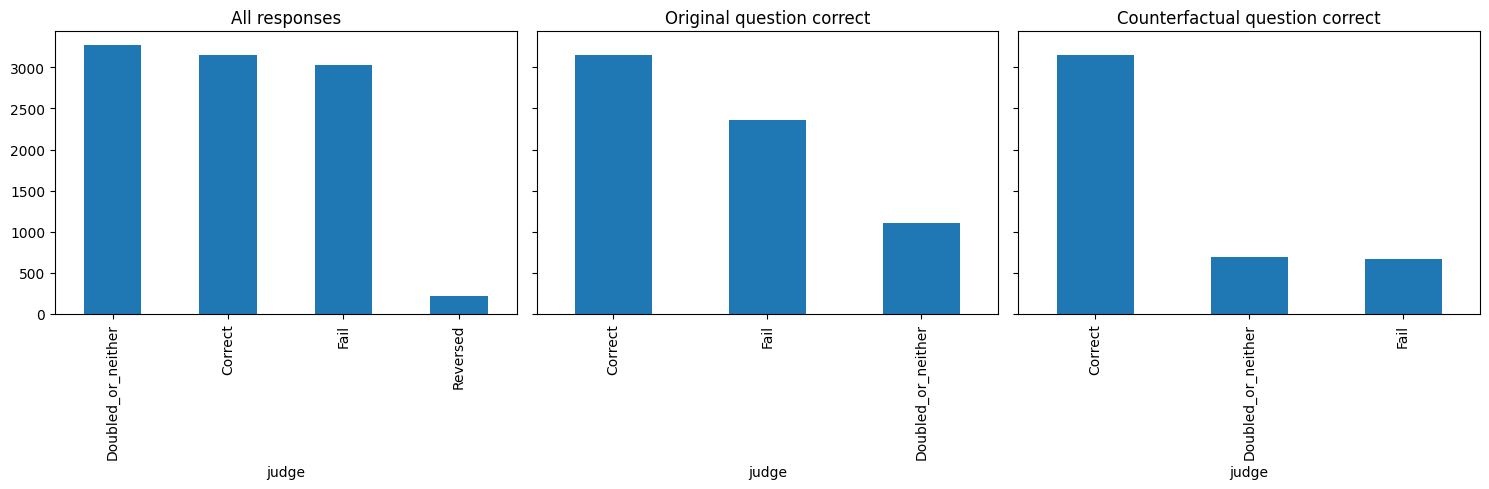

In [12]:
_, ax = plt.subplots(1,3, figsize=(15,5), sharey=True,)

responses['judge'].value_counts().plot(kind='bar', ax=ax[0], title='All responses')

# Consider numbers where the original answer was correct, regardless of the other answer
responses[responses['og_accuracy'] == True].judge.value_counts().plot(kind='bar', ax=ax[1], title='Original question correct')

# and then the same for the counterfactual
responses[responses['cf_accuracy'] == True].judge.value_counts().plot(kind='bar', ax=ax[2], title='Counterfactual question correct')

plt.tight_layout();

In [13]:
# accuracy comparisons of different Qs

dual_accuracy = responses[responses['judge'] == 'Correct'].shape[0] / responses.shape[0]

og_accuracy = responses[responses['og_accuracy'] == True].shape[0] / responses.shape[0]
cf_accuracy = responses[responses['cf_accuracy'] == True].shape[0] / responses.shape[0]

print(f'Both correct: {dual_accuracy:.2%}\nOriginal correct: {og_accuracy:.2%}\nPerturbed correct: {cf_accuracy:.2%}\n')

#f1 scores comparisons
og_f1 = responses.f11.mean()
cf_f1 = responses.f12.mean()

dual_f1 = (og_f1 + cf_f1)/2 # can take the average of averages as they are exactly the same sample sizes, otherwise this would not work correctly

print(f'Overall F1: {dual_f1:.2f}\nOriginal F1: {og_f1:.2f}\nPerturbed F1: {cf_f1:.2f}\n')

#Exact Match
print(f'EM orig: {responses.ac.sum()/len(responses):.2%}\nEM pert: {responses.ac2.sum()/len(responses):.2%}\nOverall EM {sum((responses.ac == 1.0) & (responses.ac2 == 1.0))/len(responses):.2%}')

Both correct: 32.62%
Original correct: 68.41%
Perturbed correct: 46.65%

Overall F1: 0.42
Original F1: 0.52
Perturbed F1: 0.31

EM orig: 27.70%
EM pert: 10.22%
Overall EM 4.19%


In [14]:
temp = responses[(responses.out != '') & (responses.out2 != '')]

len(temp), len(responses)

(7093, 9677)

In [15]:
# accuracy comparisons of different Qs if blank repsonses are removed

tdual_accuracy = temp[temp['judge'] == 'Correct'].shape[0] / temp.shape[0]

tog_accuracy = temp[temp['og_accuracy'] == True].shape[0] / temp.shape[0]
tcf_accuracy = temp[temp['cf_accuracy'] == True].shape[0] / temp.shape[0]

print(f'Both correct: {tdual_accuracy:.2%}\nOriginal correct: {tog_accuracy:.2%}\nPerturbed correct: {tcf_accuracy:.2%}\n')

#f1 scores comparisons
tog_f1 = temp.f11.mean()
tcf_f1 = temp.f12.mean()

tdual_f1 = (tog_f1 + tcf_f1)/2 # can take the average of averages as they are exactly the same sample sizes, otherwise this would not work correctly

print(f'Overall F1: {tdual_f1:.2f}\nOriginal F1: {tog_f1:.2f}\nPerturbed F1: {tcf_f1:.2f}\n')

#Exact Match
print(f'EM orig: {temp.ac.sum()/len(temp):.2%}\nEM pert: {temp.ac2.sum()/len(temp):.2%}\nOverall EM {sum((temp.ac == 1.0) & (temp.ac2 == 1.0))/len(temp):.2%}')

Both correct: 44.51%
Original correct: 82.36%
Perturbed correct: 55.73%

Overall F1: 0.51
Original F1: 0.64
Perturbed F1: 0.38

EM orig: 35.25%
EM pert: 12.74%
Overall EM 5.71%


#### If reasoning correctly, I would have expected similar scores for og and cf, but is this really evidence of poor reasoning? Is it an artifact of the training data, or poor question formation instead?
Cannot see that it has explicitly seen this data in it's training, but that doesn't mean much.

The questions look reasonable to me as a native speaker, however there seems to be a lot of cf questions with 'last' in which is maybe not a common way to phrase these questions? Is the differences related to the specific comparison words... also suggests not reasoning, just has learnt better heuristics to comparison words it is more familiar (mayeb) with

In [16]:
#check questions where it gave the same answer to both prompts, suggesting it was relying on a faulty heuristic rather than reasoning

for i in responses[responses['judge']=='Fail'].itertuples():
    print(f'{i.question1}, {i.question2}')
    print(f'gold_present: {i.gold_present}, wrong_present: {i.wrong_present}, gold2_present: {i.gold2_present}, wrong2_present: {i.wrong2_present}\n')

Who was born first A. I. Bezzerides or Arthur Edmund Carewe?, Who was born last A. I. Bezzerides or Arthur Edmund Carewe?
gold_present: True, wrong_present: False, gold2_present: False, wrong2_present: True

Who was born first out of Mike Delany and Glenn H. James?, Who was born last out of Mike Delany and Glenn H. James?
gold_present: True, wrong_present: False, gold2_present: False, wrong2_present: True

Who is younger, Franck Jurietti or Charles 'Pop' Fraser?, Who is older, Franck Jurietti or Charles 'Pop' Fraser?
gold_present: True, wrong_present: False, gold2_present: False, wrong2_present: True

Which film was released first, Eradu Kanasu or The Black Chapel?, Which film was released last, Eradu Kanasu or The Black Chapel?
gold_present: False, wrong_present: True, gold2_present: True, wrong2_present: False

Who was born first, Sergio Ferrari or Patrick Kane?, Who was born last, Sergio Ferrari or Patrick Kane?
gold_present: True, wrong_present: False, gold2_present: False, wrong2_

In [17]:
responses[responses['judge']=='Fail'].gold_present.value_counts() #Most gave the same answer to the original question for both.

gold_present
True     2359
False     668
Name: count, dtype: int64

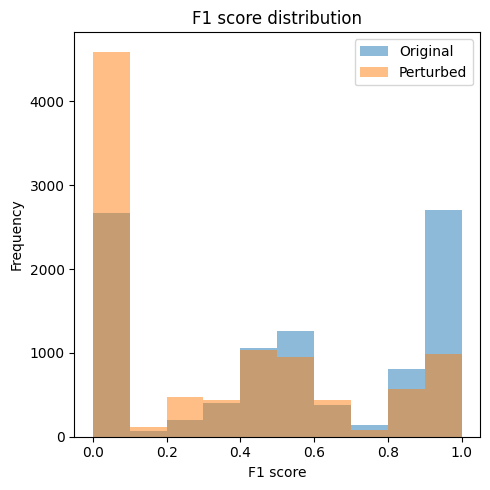

In [18]:
_,ax = plt.subplots(1,1, figsize=(5,5), sharey=True)

bins = np.arange(0,1.1,0.1)

responses.f11.plot(kind='hist', bins=bins, ax=ax, alpha=0.5, label='Original')
responses.f12.plot(kind='hist', bins=bins, ax=ax, alpha=0.5, label='Perturbed')

plt.title('F1 score distribution')
plt.xlabel('F1 score')
plt.legend()
plt.tight_layout()
plt.savefig('../images/f1_dist.png')

In [19]:
a = responses[responses.f11 < 0.1].shape[0]
b = responses[responses.f12 < 0.1].shape[0]

print(a, b, a/(a+b), b/(a+b))

2672 4593 0.36779077770130764 0.6322092222986924


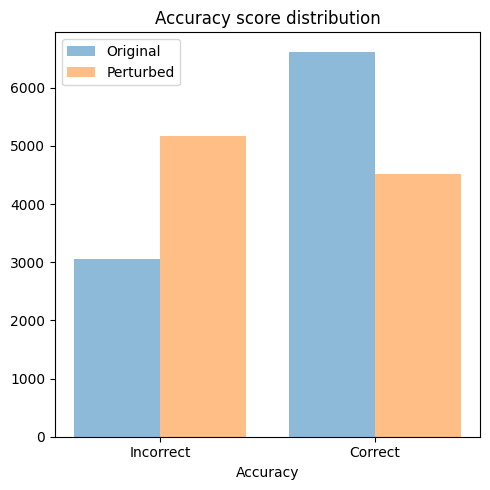

In [20]:
_,ax = plt.subplots(1,1, figsize=(5,5), sharey=True)

plt.bar([0.8,-0.2],[v for k,v in responses.og_accuracy.value_counts().items()], alpha=0.5, label='Original', width=0.4)
plt.bar([0.2,1.2],[v for k,v in responses.cf_accuracy.value_counts().items()], alpha=0.5, label='Perturbed', width=0.4)

plt.title('Accuracy score distribution')
plt.xlabel('Accuracy')
plt.xticks([0,1], ['Incorrect', 'Correct'])
plt.legend()
plt.tight_layout()
plt.savefig('../images/acc_dist.png')

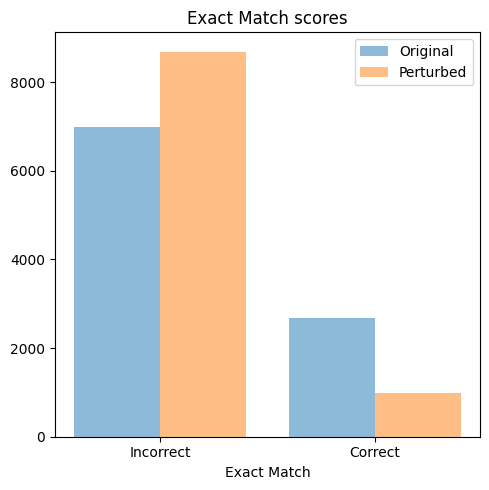

In [21]:
_,ax = plt.subplots(1,1, figsize=(5,5), sharey=True)

plt.bar([-0.2,0.8],[v for k,v in responses.ac.value_counts().items()], alpha=0.5, label='Original', width=0.4)
plt.bar([0.2,1.2],[v for k,v in responses.ac2.value_counts().items()], alpha=0.5, label='Perturbed', width=0.4)

plt.title('Exact Match scores')
plt.xlabel('Exact Match')
plt.xticks([0,1], ['Incorrect', 'Correct'])
plt.legend()
plt.tight_layout()
plt.savefig('../images/EM_bars.png')

In [22]:
change = ['first','last','earlier','later','younger','older','recently']
idx = {'first':[], 'last':[], 'earlier':[], 'later':[], 'younger':[], 'older':[], 'recently':[]}
responses[['orig_comp','cf_comp']] = ''

#find the comparator in each question
#get counts of the specific comparitors in each pair of questions
comparator1 = Counter()
comparator2 = Counter()

for i in responses.itertuples():
    comps = []
    text = i.question1.replace("?",' ').replace(",",' ').replace("'",' ').replace(":",' ').replace(";",' ').replace("--",' ').replace(".", ' ')
    for word in text.split(' '):
        if word in change:
            comps.append(word)
            idx[word].append(i.Index)
    if len(comps) == 0:
        print(comps)
    if len(comps) != 1:
        print(i, comps)
        comparator1.update([comps[0]])
    else:
        responses.loc[i.Index, 'orig_comp'] = comps[0]
        comparator1.update(comps)

    comps = []
    text = i.question2.replace("?",' ').replace(",",' ').replace("'",' ').replace(":",' ').replace(";",' ').replace("--",' ').replace(".", ' ')
    for word in text.split(' '):
        if word in change:
            comps.append(word)
            idx[word].append(i.Index)
    if len(comps) != 1:
        print(i, comps)
        comparator2.update([comps[0]])
    else:
        responses.loc[i.Index, 'cf_comp'] = comps[0]
        comparator2.update(comps)
    
    

comparator1, comparator2

(Counter({'first': 4513,
          'earlier': 2063,
          'later': 1038,
          'older': 976,
          'younger': 761,
          'recently': 326}),
 Counter({'last': 4513,
          'later': 2063,
          'earlier': 1364,
          'younger': 976,
          'older': 761}))

In [23]:
for i in [4513, 2063, 1038, 976, 761, 326, 4513, 2063, 1364, 976, 761]:
    print((f'{i}, {i/9677:.1%}'))

4513, 46.6%
2063, 21.3%
1038, 10.7%
976, 10.1%
761, 7.9%
326, 3.4%
4513, 46.6%
2063, 21.3%
1364, 14.1%
976, 10.1%
761, 7.9%


In [24]:
responses[(responses['judge']=='Fail') & (responses.gold_present==True)].orig_comp.value_counts()

orig_comp
first       1740
earlier      362
older         94
later         70
younger       51
recently      42
Name: count, dtype: int64

In [25]:
responses[(responses['judge']=='Fail') & (responses.gold2_present==True)].orig_comp.value_counts()

orig_comp
first       236
later       161
earlier     117
older        73
younger      46
recently     35
Name: count, dtype: int64

In [26]:
#compare the accuracy of the questions with the specific comparators

for word in change:
    print(f'\n*** {word} ***')
    temp = responses[responses.orig_comp == word]
    print(f'as og\nf1 og: {temp.f11.mean():.2f}\nf1 cf: {temp.f12.mean():.2f}')
    print(f'EM og: {temp.ac.mean():.2f}\nEM cf: {temp.ac2.mean():.2f}')
    print(f'accuracy og: {temp.og_accuracy.mean():.2f}\naccuracy cf: {temp.cf_accuracy.mean():.2f}\ncount: {temp.shape[0]}')
    nn = temp.shape[0]
    for k, v in temp.judge.value_counts().items():
        print(f'{k}: {v}, {v/nn:.1%}')

    temp = responses[responses.cf_comp == word]
    print(f'as cf\nf1 og: {temp.f11.mean():.2f}\nf1 cf: {temp.f12.mean():.2f}')
    print(f'EM og: {temp.ac.mean():.2f}\nEM cf: {temp.ac2.mean():.2f}')
    print(f'accuracy og: {temp.og_accuracy.mean():.2f}\naccuracy cf: {temp.cf_accuracy.mean():.2f}\ncount: {temp.shape[0]}')
    nn = temp.shape[0]
    for k, v in temp.judge.value_counts().items():
        print(f'{k}: {v}, {v/nn:.1%}\n{"*"*10}')


*** first ***
as og
f1 og: 0.58
f1 cf: 0.23
EM og: 0.35
EM cf: 0.08
accuracy og: 0.74
accuracy cf: 0.34
count: 4513
Fail: 1976, 43.8%
Doubled_or_neither: 1332, 29.5%
Correct: 1104, 24.5%
Reversed: 101, 2.2%
as cf
f1 og: nan
f1 cf: nan
EM og: nan
EM cf: nan
accuracy og: nan
accuracy cf: nan
count: 0

*** last ***
as og
f1 og: nan
f1 cf: nan
EM og: nan
EM cf: nan
accuracy og: nan
accuracy cf: nan
count: 0
as cf
f1 og: 0.58
f1 cf: 0.23
EM og: 0.35
EM cf: 0.08
accuracy og: 0.74
accuracy cf: 0.34
count: 4513
Fail: 1976, 43.8%
**********
Doubled_or_neither: 1332, 29.5%
**********
Correct: 1104, 24.5%
**********
Reversed: 101, 2.2%
**********

*** earlier ***
as og
f1 og: 0.59
f1 cf: 0.39
EM og: 0.35
EM cf: 0.15
accuracy og: 0.74
accuracy cf: 0.57
count: 2063
Correct: 928, 45.0%
Doubled_or_neither: 604, 29.3%
Fail: 479, 23.2%
Reversed: 52, 2.5%
as cf
f1 og: 0.40
f1 cf: 0.46
EM og: 0.16
EM cf: 0.17
accuracy og: 0.57
accuracy cf: 0.65
count: 1364
Correct: 560, 41.1%
**********
Doubled_or_neith

In [27]:
responses[responses.index=='2wiki-fe76f69408ed11ebbda8ac1f6bf848b6']

,gold_present,wrong_present,gold2_present,wrong2_present,out,out2,order,question1,question2,f11,f12,ac,ac2,judge,og_accuracy,cf_accuracy,orig_comp,cf_comp
2wiki-fe76f69408ed11ebbda8ac1f6bf848b6,True,False,True,False,Kristine Saastad,Zhang Yangming,orig,"Who was born earlier, Kristine Saastad or Zhan...","Who was born later, Kristine Saastad or Zhang ...",1.0,1.0,1.0,1.0,Correct,1,1,earlier,later


In [28]:
responses.to_csv('../data/responses.csv') #save dataframe for cross analysis with IG results